# Regression –   Homework

**Task overview**
- Regression analysis of Air Quality dataset: https://archive.ics.uci.edu/ml/datasets/Air+Quality#
- Target - C6H6(GT)
- -200 indicates missing values

**Evaluation Criteria**

Scoring (10 max):
- EDA: exploration of variables and properties of data with conclusions -  1
- Data preparation: all missing values are filled/dropped with explanation of why some methodwas chosen -  1
- Data preparation: normalization of data / scaling -  1
- Baseline model - linear regression without regularization - 1
- Feature engineering -  basic transformations (nonlinear) -  2
- Metrics chosen as well as reasoning behind each metric - 1
- Feature importance, hyperparameters tuning -  1
- Statistics material used (residual analysis, factor-importance hypothesis testing) - 1
- Non-classic regression (SVM-regression, Kernel-regression, SGD-regression) -  1

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR

warnings.filterwarnings("ignore")
sns.set()
%matplotlib inline

## EDA

First, we'll load the dataset, delete all-NaN rows and columns. Also we'll drop date and time from the start as time-series analysis is clearly out of the scope of the task.

In [2]:
TARGET = 'C6H6(GT)'

df = pd.read_csv('AirQualityUCI.csv', sep=';', na_values=['-200'], decimal=',')
df.drop(['Unnamed: 15', 'Unnamed: 16'], inplace=True, axis=1)
df.drop(['Date', 'Time'], inplace=True, axis=1)
df.dropna(how='all', inplace=True)

df.tail()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
9352,3.1,1314.0,NaN,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
9353,2.4,1163.0,NaN,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
9354,2.4,1142.0,NaN,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406
9355,2.1,1003.0,NaN,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139
9356,2.2,1071.0,NaN,11.9,1047.0,265.0,654.0,168.0,1129.0,816.0,28.5,13.1,0.5028


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9326 entries, 0 to 9356
Data columns (total 13 columns):
CO(GT)           7674 non-null float64
PT08.S1(CO)      8991 non-null float64
NMHC(GT)         914 non-null float64
C6H6(GT)         8991 non-null float64
PT08.S2(NMHC)    8991 non-null float64
NOx(GT)          7718 non-null float64
PT08.S3(NOx)     8991 non-null float64
NO2(GT)          7715 non-null float64
PT08.S4(NO2)     8991 non-null float64
PT08.S5(O3)      8991 non-null float64
T                8991 non-null float64
RH               8991 non-null float64
AH               8991 non-null float64
dtypes: float64(13)
memory usage: 1020.0 KB


Let's drop **NMHC(GT)** as most of its values are null.

In [4]:
df.drop(['NMHC(GT)'], inplace=True, axis=1)

Now, how many rows containing NaN values do we have?

In [5]:
rows_with_nan = sum([True for idx,row in df.iterrows() if any(row.isnull())])
print('Rows with NaN: %i (%.0f%%)' % (rows_with_nan, rows_with_nan * 100 / len(df)))

Rows with NaN: 2385 (26%)


Quite a lot. But still tempting to drop them all for our analysis:

In [6]:
orig_length = len(df)
df.dropna(inplace=True)
new_length = len(df)
print('Rows dropped:', orig_length - new_length)

Rows dropped: 2385


A few words about why we're eager to sacrifice one fourth of the dataset so easily.

The answer is - for the sake of simplicity. We still can inspect relations between features, build initial model or do feature selection and get back to inspecting and imputing missing values if we have reason to think that our model would benefit from more data (even though incomplete). But for now we will let them go.

Now let's take a look at box plots for each feature to check for outliers.

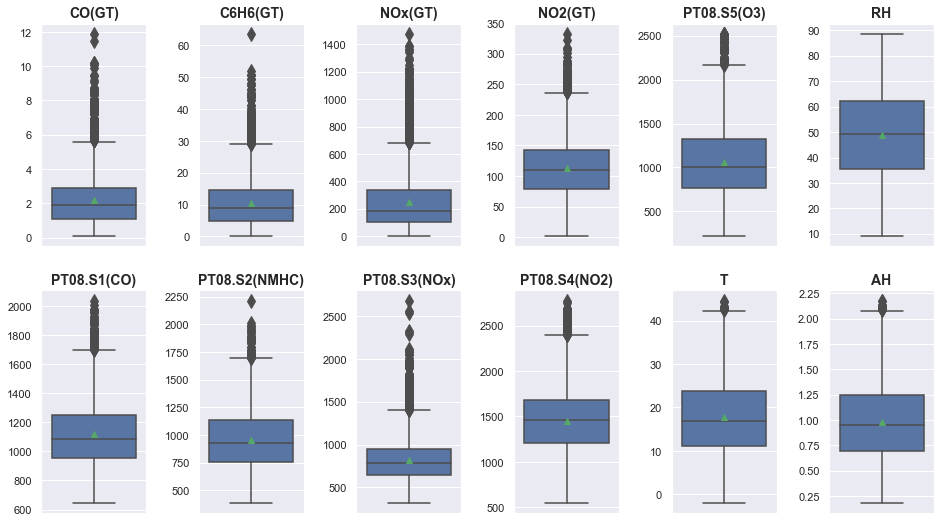

In [7]:
def show_boxplot(df, nrows=2):
    ncols = int(np.ceil(len(df.columns.values) / nrows))
    f, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 9))
    plt.subplots_adjust(wspace=0.5)
    for index, column_name in enumerate(df.columns.values):
        ax=axes[index % nrows][index // nrows]
        sns.boxplot(data=df, y=column_name, ax=ax, fliersize=10, showmeans=True)
        ax.set_title(column_name, fontsize=14, fontweight='bold')
        ax.set_ylabel('')

show_boxplot(df)

Luckily no promiment outliers here. Now let's look at scatterplots and distribution plots:

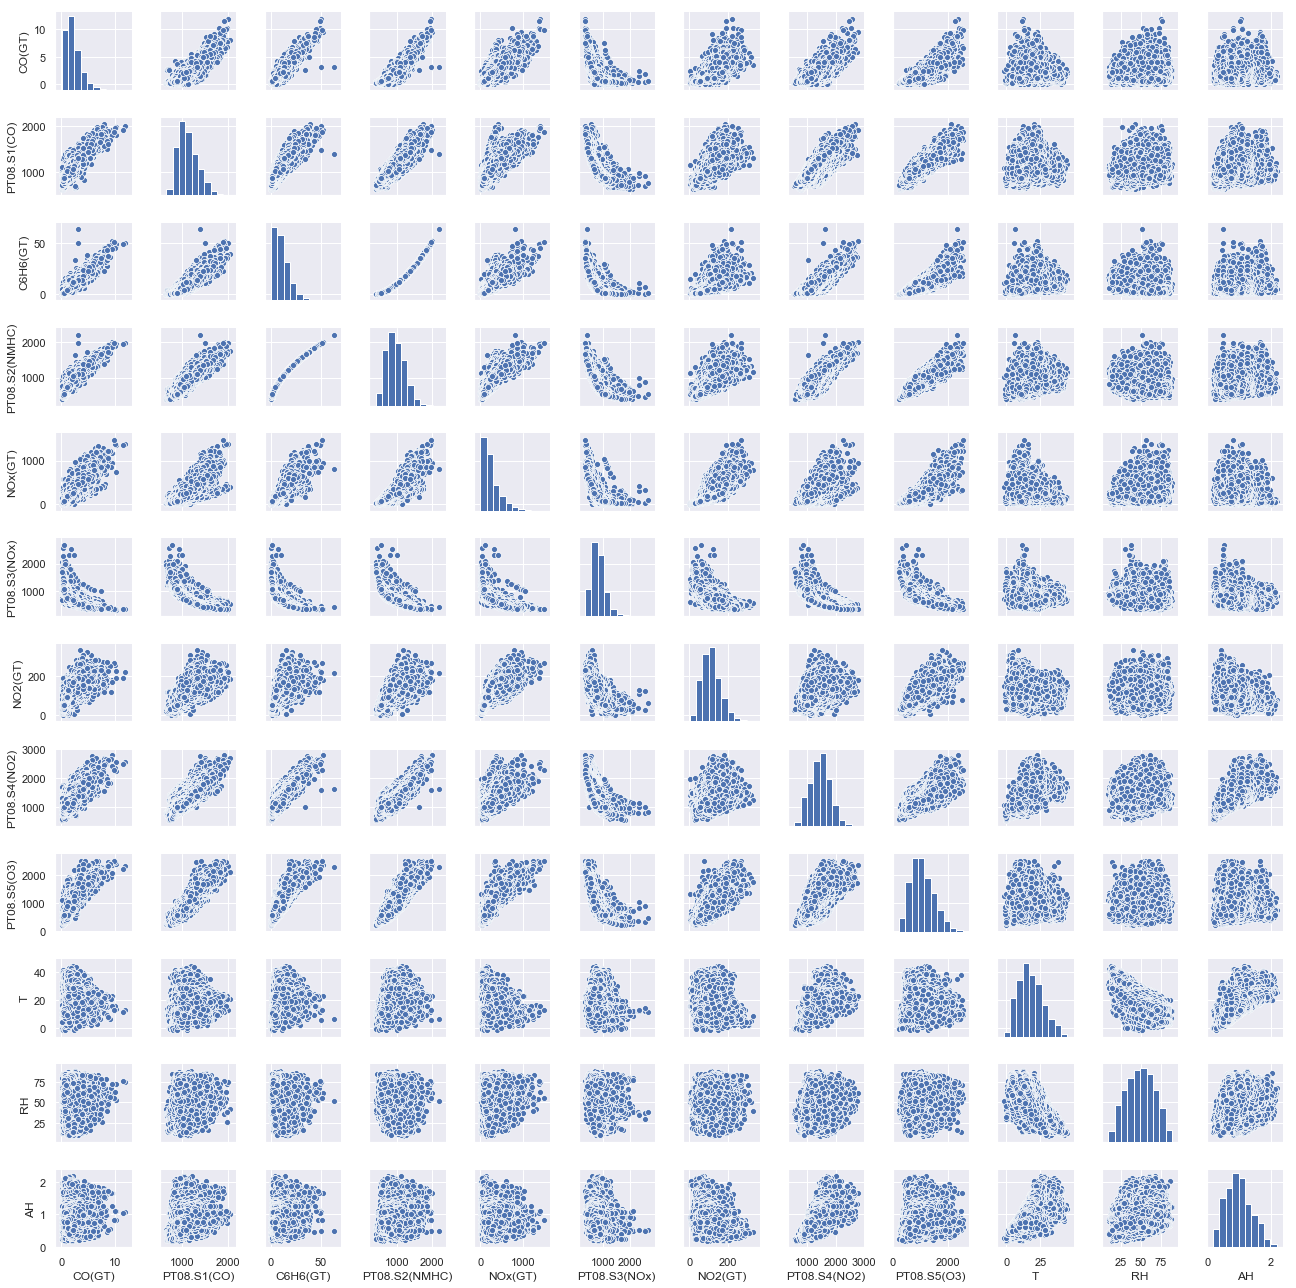

In [8]:
sns.pairplot(df, height=1.5)
plt.show()

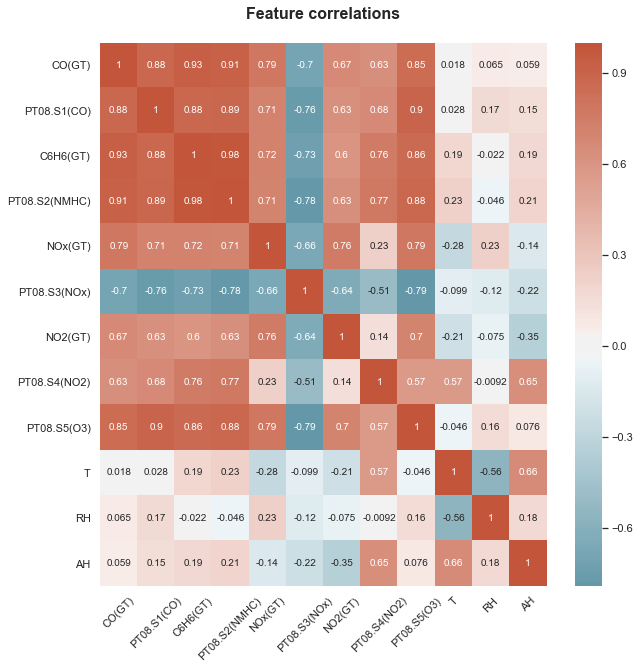

In [9]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), center=0, cmap=sns.diverging_palette(220, 20, as_cmap=True), annot=True)
plt.title('Feature correlations\n', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.show()

Takeaways from the charts:
- Feature **PT08.S2(NMHC)** alone could drive our model as we see strong correlation with the target. Also we could apply transormation to make this relation linear
- Weather-related features (**T, RH, AH**) seem to be unrelated to our target or other predictors which represent data from chemical sensors. Adding weather is likely to only introduce noise to our model.
- All sensor measurements are highly correlated. To explain this observation we could read dataset description and discover that sensors are likely to be installed near the road. Also it mentions *cross-sensitivities* between different sensors. **PT08.S3(NOx)** is special to show negative correlation with other sensors but it is hard to tell why it is so special without certain degree of domain knowledge (my guess is tungsten oxide is the only chemical in the list that is not found in car vents and is affected by external factor).

In the scope of regression analysis we should deal with this multicollinearity by applying feature selection to avoid model instability and overfitting. We could easily insert PCA in the pipeline to reduce the number of dimensions but we would then lose interpretability of the model. Instead we will use L1-regularization (see "Feature selection" section).

Let's drop weather-related features:

In [10]:
df.drop(['T', 'RH', 'AH'], inplace=True, axis=1)

## Data preparation

We will use simple train-dev-test splitting scheme:

In [11]:
target = df[TARGET]
features = df.drop(TARGET, axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    features, target, random_state=42
)

Let's apply scaling so that all our features have the same mean and variance (and we don't have to apply variance-dependent weights to our loss function):

In [12]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Baseline model

As a baseline we will use linear regression without any regularization.

In [13]:
model = LinearRegression().fit(X_train_scaled, y_train)
print("Training set score: {:.4f}".format(model.score(X_train_scaled, y_train)))
print("Test set score: {:.4f}".format(model.score(X_test_scaled, y_test)))

Training set score: 0.9774
Test set score: 0.9800


That's quite a lot for a start. Let's take a look at chart that show residuals vs fitted values (along with their distributions):

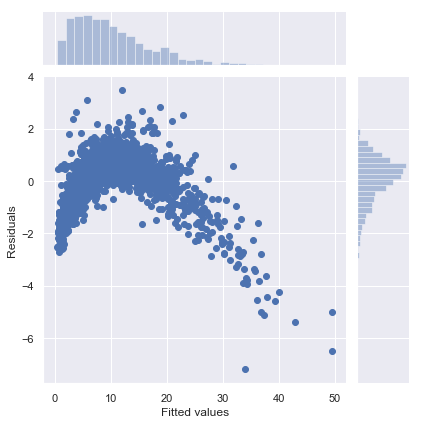

In [14]:
predictions = model.predict(X_test_scaled)
residuals = predictions - y_test
sns.jointplot(x=y_test, y=residuals).set_axis_labels("Fitted values", "Residuals")
plt.show()

Distribution of residuals is more-or-less normal. But if residuals depend on fitted values we should use a nonlinear model.

## Feature selection

First let's use L1 regression to select most relevant features for further modelling. In order to do that we will use cross-validation and grid search with varying regularization parameter *alpha*. We will inspect mean dev set scores for each value of *alpha*.

This is not the only way to do feature selection (e.g. iterative manual elimination) but we will stick to this one.

In [15]:
param_grid = {'alpha': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]}
grid_search = GridSearchCV(Lasso(), param_grid, cv=5)

grid_search.fit(X_train, y_train)
results = pd.DataFrame(grid_search.cv_results_)
results[['param_alpha', 'mean_test_score']]

,param_alpha,mean_test_score
0,0.001,0.977037
1,0.003,0.977038
2,0.01,0.977034
3,0.03,0.976978
4,0.1,0.976266
5,0.3,0.974661
6,1,0.974622
7,3,0.974285
8,10,0.973310
9,30,0.970607


We see that model accuracy rapidly drops for *alpha* values greater than 300. So let's use 300 for feature selection and see what model coefficient will be nonzero in that case:

In [16]:
lasso = Lasso(alpha=100).fit(X_train, y_train)
coefs = pd.DataFrame({'coef': lasso.coef_}, index=X_train.columns.values)
coefs = coefs[coefs.coef != 0].sort_values('coef', ascending=False)

FEATURE_SUBSET = list(coefs.index.values)

print('Total features:', len(X_train.columns.values))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))
coefs

Total features: 8
Number of features used: 3


,coef
PT08.S2(NMHC),0.024566
PT08.S5(O3),0.001040
PT08.S4(NO2),0.000369


As we could expect **PT08.S2(NMHC)** is the killer feature here.

For further work let's inspect these features (along with the target) more closely.

## Feature engineering

Having selected subset of features let's do some "feature engineering".

The most important thing we can do here is to try to apply some transformation to **PT08.S2(NMHC)** to linearize its relation with **C6H6(GT)**. Luckily simple squaring will do the thing.

We could also do similar thing for other features but we won't bother because they are not that skewed and benefits are not immediately obvious.

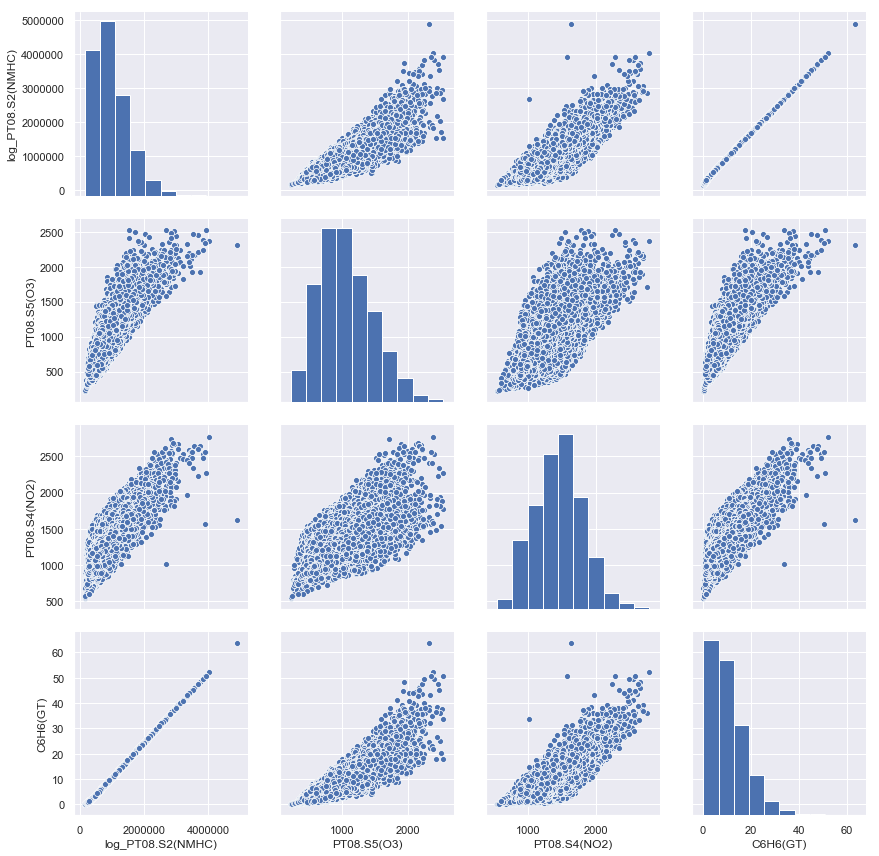

In [27]:
df_proc = df[FEATURE_SUBSET + [TARGET]]
df_proc.insert(0, 'log_PT08.S2(NMHC)', df_proc['PT08.S2(NMHC)'] ** 2)
df_proc.drop(['PT08.S2(NMHC)'], inplace=True, axis=1)

sns.pairplot(df_proc, height=3)
plt.show()

## Building the model

We will use linear regression, L2-regularization, 3-degree polynomial features, least squares for optimization objective and R2 score for both cross-validation and model evaluation.

#### Why linear regression?

After logarithmic transformation our target has obvious linear relation with **PT08.S2(NMHC)** which will dominate our predictions. No reason to use more complex nonlinear models here (and it will be hard to observe benefits they provide).

#### Why polynomial features?

For the sake of exercise.

#### Why least squares for optimization objective?

We can assume noise in residuals to be gaussian and lacking extreme outliers (see residual chart for baseline model). No good reasons to  give up computational efficiency and stability of "default" option.


#### Why R2 score for cross-validation and evaluation?

No specific requirements or criteria of model quality were provided in the task description. So we'll stick to "default" and easily interpretable statistical metric for linear regression.

In [29]:
target = df_proc[TARGET]
features = df_proc.drop(TARGET, axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    features, target, random_state=42
)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Our model will be dominated by single feature anyway but for the sake of excercise let's use polynomial features up to third degree:

In [30]:
poly = PolynomialFeatures(degree=3).fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

Now we apply grid search to find the best value of regularization parameter.

In [31]:
param_grid = {'alpha': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]}
grid_search = GridSearchCV(Ridge(), param_grid, cv=5)
grid_search.fit(X_train_poly, y_train)

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.6f}".format(grid_search.best_score_))
print("Test set score: {:.6f}".format(grid_search.score(X_test_poly, y_test)))

Best parameters: {'alpha': 0.1}
Best cross-validation score: 0.999943
Test set score: 0.999947


Let's take a look at residuals:

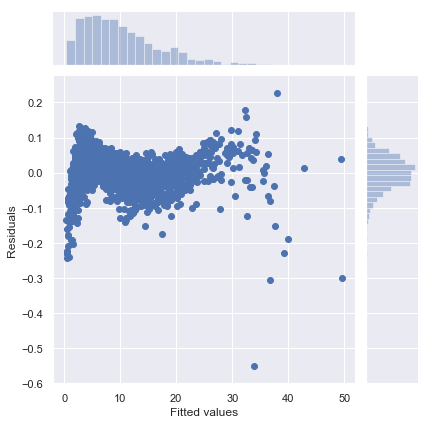

In [35]:
predictions = grid_search.predict(X_test_poly)
residuals = predictions - y_test
sns.jointplot(x=y_test, y=residuals).set_axis_labels("Fitted values", "Residuals")
plt.show()

Much more better than our baseline model but we still have some room for improvement as we clearly observe a non-uniformity pattern of variance of residuals. Fine tuning of the model and the pipeline could reduce this effect and slightly improve our 99.99% score but we will stop at this point for now.

## SVM regression

Let's try to achieve similar score using just a single feature without manual transformations.

We will employ SVR with different nonlinear kernels.

In [52]:
target = df[TARGET]
features = df[['PT08.S2(NMHC)']]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, random_state=42
)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

params = [
    {
        'kernel': ['rbf'],
        'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5],
        'C': [1, 10, 100, 1000],
    },
    {
        'kernel': ['poly'],
        'degree': [2],
        'C': [1, 10, 100, 1000],
    },
]

svr = GridSearchCV(SVR(), params, cv=5)
svr.fit(X_train_scaled, y_train)

print("Best parameters:", svr.best_params_)
print("Mean validation set score: %.6f" % svr.best_score_)
print("Test set score: %.6f" % svr.score(X_test_scaled, y_test))

Best parameters: {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
Mean validation set score: 0.999955
Test set score: 0.999962


Let's take a look at residuals:

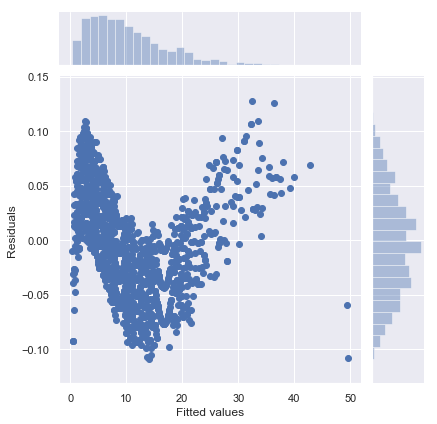

In [53]:
predictions = svr.predict(X_test_scaled)
residuals = predictions - y_test
sns.jointplot(x=y_test, y=residuals).set_axis_labels("Fitted values", "Residuals")
plt.show()

Well, actually SVR with single untransformed killer-feature works just as well as linear regression with manual feature engineering. Though training model training took much more time in this case.

We could probably just as well stick to using single feature for linear regression but let's not bother to rigorously check this assumption.

Again, residual plot suggests we could possibly do even better.

## Conclusion

We can provide almost perfect predictions for target using only **PT08.S2(NMHC)** feature. They have non-linear (quadratic) relation.

Adding any other features would just introduce noise.